## **PROCDUCT CATEGORIZATION PROJECT**


## 1. Importing Libraries and Loading Data

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud


# File paths for the Project
train_data_file = '/content/drive/MyDrive/upGrad_Hackathon/train_product_data.csv'
test_data_file = '/content/drive/MyDrive/upGrad_Hackathon/test_data.csv'
test_results_file = '/content/drive/MyDrive/upGrad_Hackathon/test_results.csv'

# Loading the datasets
train_data = pd.read_csv(train_data_file)
test_data = pd.read_csv(test_data_file)
test_results = pd.read_csv(test_results_file)


## 2. Preprocessing and Text Cleaning

In [21]:
# Preprocessing function
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

def preprocess_text(text):

    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    text = str(text).lower()
    text = ''.join([char for char in text if char.isalnum() or char.isspace()])
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

# Apply preprocessing to training data
train_data['cleaned_description'] = train_data['description'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# 3. Exploratory Data Analysis (EDA)

        retail_price  discounted_price
count   14942.000000      14942.000000
mean     3128.424040       2087.732298
std      9154.463342       7712.247869
min        35.000000         35.000000
25%       699.000000        349.000000
50%      1000.000000        499.000000
75%      1989.750000        999.000000
max    571230.000000     571230.000000
uniq_id                       0
crawl_timestamp               0
product_url                   0
product_name                  0
product_category_tree         0
pid                           0
retail_price                 57
discounted_price             57
image                         3
is_FK_Advantage_product       0
description                   1
product_rating                0
overall_rating                0
brand                      4710
product_specifications        6
cleaned_description           0
dtype: int64


<ipython-input-22-c2c5e4b22c50>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=train_data['product_category_tree'], order=train_data['product_category_tree'].value_counts().index, palette="viridis")


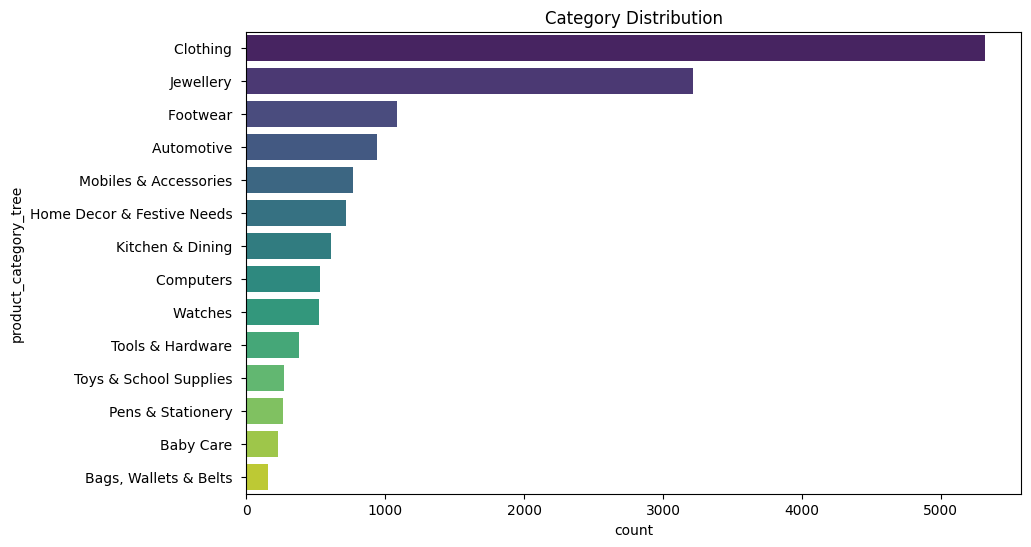

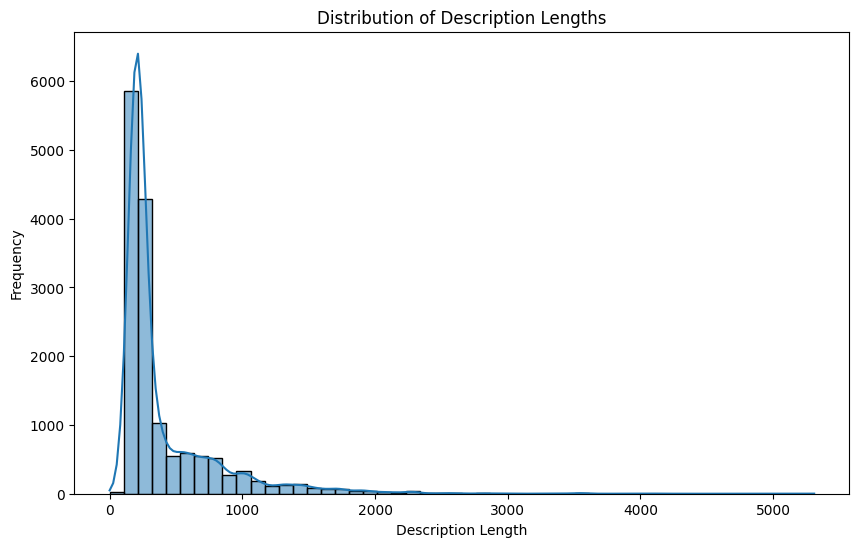

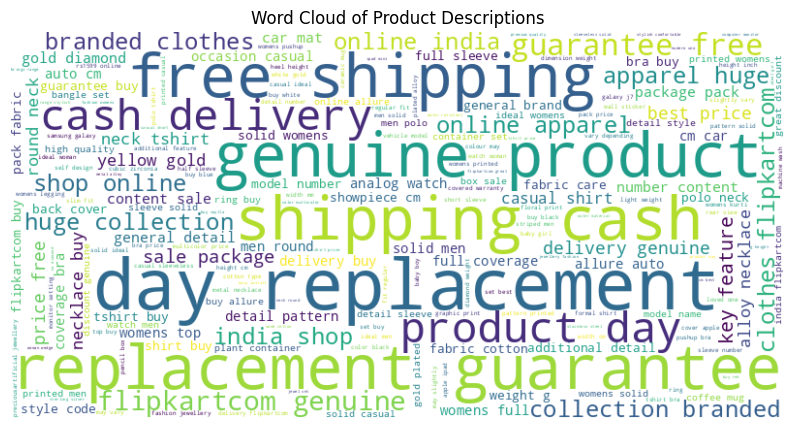

In [22]:
# Display basic statistics and missing values
print(train_data.describe())
print(train_data.isnull().sum())

# Distribution of product categories
plt.figure(figsize=(10, 6))
sns.countplot(y=train_data['product_category_tree'], order=train_data['product_category_tree'].value_counts().index, palette="viridis")
plt.title('Category Distribution')
plt.show()

# Distribution of description lengths
train_data['description_length'] = train_data['description'].apply(lambda x: len(str(x)) if not isinstance(x, float) else 0)
plt.figure(figsize=(10,6))
sns.histplot(train_data['description_length'], bins=50, kde=True)
plt.title('Distribution of Description Lengths')
plt.xlabel('Description Length')
plt.ylabel('Frequency')
plt.show()

# Word Cloud
train_data['cleaned_description'] = train_data['description'].apply(preprocess_text)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text) # Now WordCloud is defined
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Product Descriptions')
plt.show()

# 4. Label Encoding and GloVe Embeddings

In [23]:
# Label encoding for product categories
label_encoder = LabelEncoder()
train_data['product_category_tree'] = label_encoder.fit_transform(train_data['product_category_tree'])

# Load GloVe embeddings
embedding_index = {}
embedding_dim = 100
glove_file = '/content/drive/MyDrive/upGrad_Hackathon/glove.6B.100d.txt'

with open(glove_file, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coeffs = np.array(values[1:], dtype='float32')
        embedding_index[word] = coeffs

# Create document embeddings
def create_document_embedding(text, embedding_index, embedding_dim):
    tokens = text.split()
    valid_vectors = [embedding_index[word] for word in tokens if word in embedding_index]
    if valid_vectors:
        return np.mean(valid_vectors, axis=0)
    else:
        return np.zeros(embedding_dim)

train_data['doc_embedding'] = train_data['cleaned_description'].apply(lambda x: create_document_embedding(x, embedding_index, embedding_dim))


# 5. Preparing Training Data

In [24]:
# Prepare training data
X_train_traditional = np.stack(train_data['doc_embedding'].values)
y_train_traditional = train_data['product_category_tree']


# 6. Model Training

In [25]:
# Train models
# Logistic Regression
lr_model = LogisticRegression()
lr_model.fit(X_train_traditional, y_train_traditional)

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train_traditional, y_train_traditional)

# XGBoost
# Adding objective='multi:softmax' to handle multi-class classification explicitly.
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', objective='multi:softmax')
xgb_model.fit(X_train_traditional, y_train_traditional)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:50:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softmax', ...)

# 7. Prepare Test Data

In [26]:
# Prepare test data
test_data['cleaned_description'] = test_data['description'].apply(preprocess_text)
test_data['doc_embedding'] = test_data['cleaned_description'].apply(lambda x: create_document_embedding(x, embedding_index, embedding_dim))
X_test_traditional = np.stack(test_data['doc_embedding'].values)

# Predict using models
y_test_pred_lr = lr_model.predict(X_test_traditional)
y_test_pred_rf = rf_model.predict(X_test_traditional)
y_test_pred_xgb = xgb_model.predict(X_test_traditional)

# Save predictions to the test_data DataFrame
test_data['Predicted_Category_LR'] = label_encoder.inverse_transform(y_test_pred_lr)
test_data['Predicted_Category_RF'] = label_encoder.inverse_transform(y_test_pred_rf)
test_data['Predicted_Category_XGB'] = label_encoder.inverse_transform(y_test_pred_xgb)


# 8. Model Evaluation and Visualization


Accuracy on Test Results (Logistic Regression): 0.8102

Accuracy on Test Results (Random Forest): 0.7762

Accuracy on Test Results (XGBoost): 0.8031


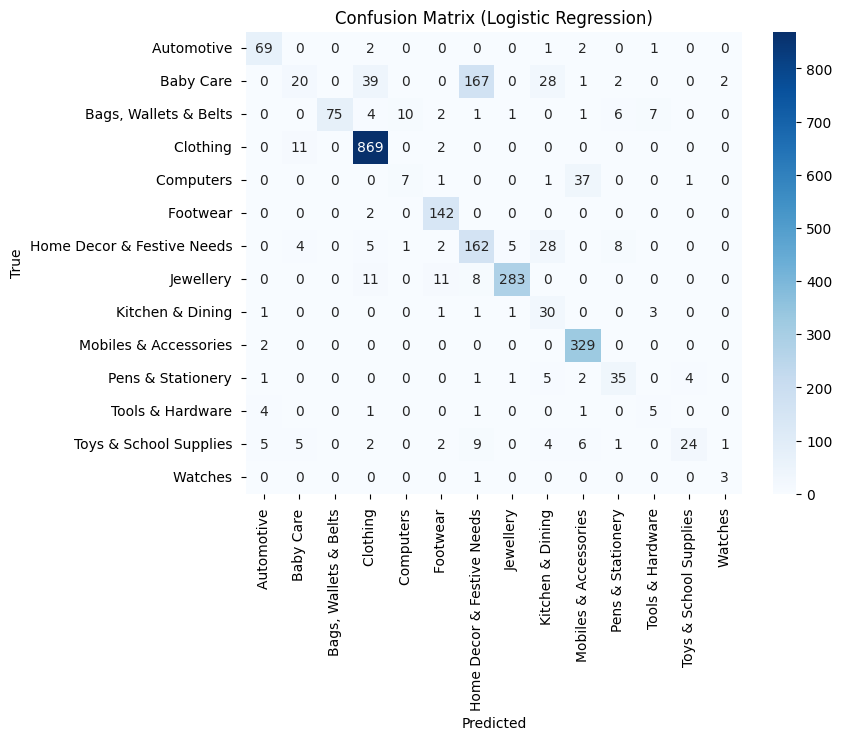

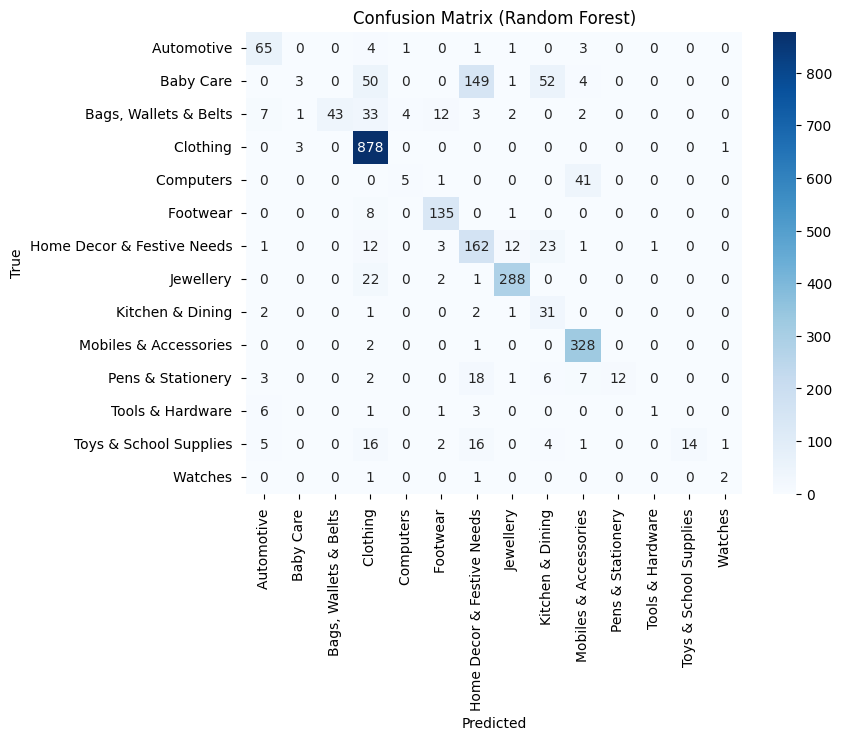

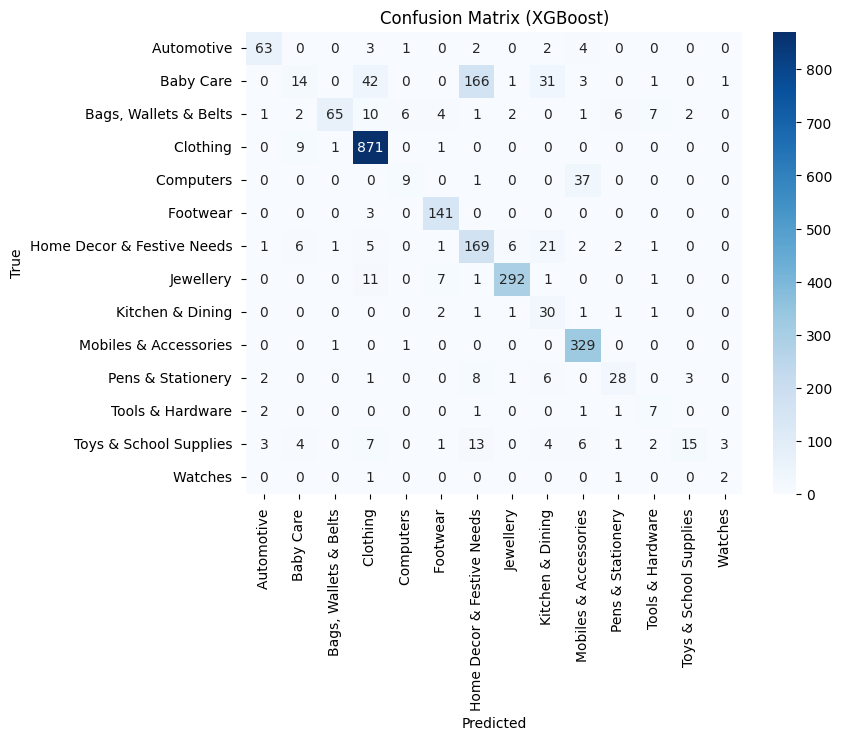

<ipython-input-27-36da3cd7577d>:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=accuracies, palette='viridis')


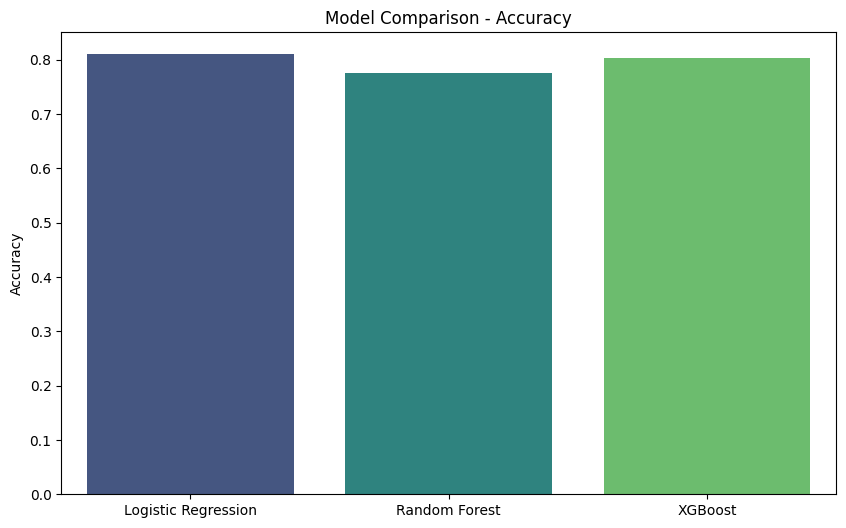

Predictions saved to 'test_data_with_predictions.csv'.


In [27]:
# Compare predictions with test_results if available
if 'product_category_tree' in test_results.columns:
    true_labels = label_encoder.transform(test_results['product_category_tree'])

    accuracy_lr = accuracy_score(true_labels, y_test_pred_lr)
    accuracy_rf = accuracy_score(true_labels, y_test_pred_rf)
    accuracy_xgb = accuracy_score(true_labels, y_test_pred_xgb)

    print(f"\nAccuracy on Test Results (Logistic Regression): {accuracy_lr:.4f}")
    print(f"\nAccuracy on Test Results (Random Forest): {accuracy_rf:.4f}")
    print(f"\nAccuracy on Test Results (XGBoost): {accuracy_xgb:.4f}")

# Visualizations

# Logistic Regression - Confusion Matrix
conf_matrix_lr = confusion_matrix(true_labels, y_test_pred_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lr, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix (Logistic Regression)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Random Forest - Confusion Matrix
conf_matrix_rf = confusion_matrix(true_labels, y_test_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix (Random Forest)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# XGBoost - Confusion Matrix
conf_matrix_xgb = confusion_matrix(true_labels, y_test_pred_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix (XGBoost)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Model comparison - Accuracy Bar Plot
accuracies = [accuracy_lr, accuracy_rf, accuracy_xgb]
model_names = ['Logistic Regression', 'Random Forest', 'XGBoost']

plt.figure(figsize=(10, 6))
sns.barplot(x=model_names, y=accuracies, palette='viridis')
plt.title('Model Comparison - Accuracy')
plt.ylabel('Accuracy')
plt.show()

# Save final test data with predictions
test_data.to_csv('test_data_with_predictions.csv', index=False)
print("Predictions saved to 'test_data_with_predictions.csv'.")
